In [1]:
# Author: Konstantin Kuchenmeister
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from keras.models import Sequential
from keras.layers import Dense
from datetime import date, timedelta # Date Functions
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from statsmodels.graphics import tsaplots

# 1. Read in and visualize data
For future work, the data pipeline could be automatised using the yahoo finance pkg yfinance (pip install yfinance).  
We are cutting away the first 5000 values, since this this time frame featured an insubtantial first and second moments. 
Empirically, I found that this holds the model back from modelling the steep increase throughout the last 3500 days.
Although the data shows clearly, that the moments depend on time t, for LSTM's it is not necessary to make the time series stationary.

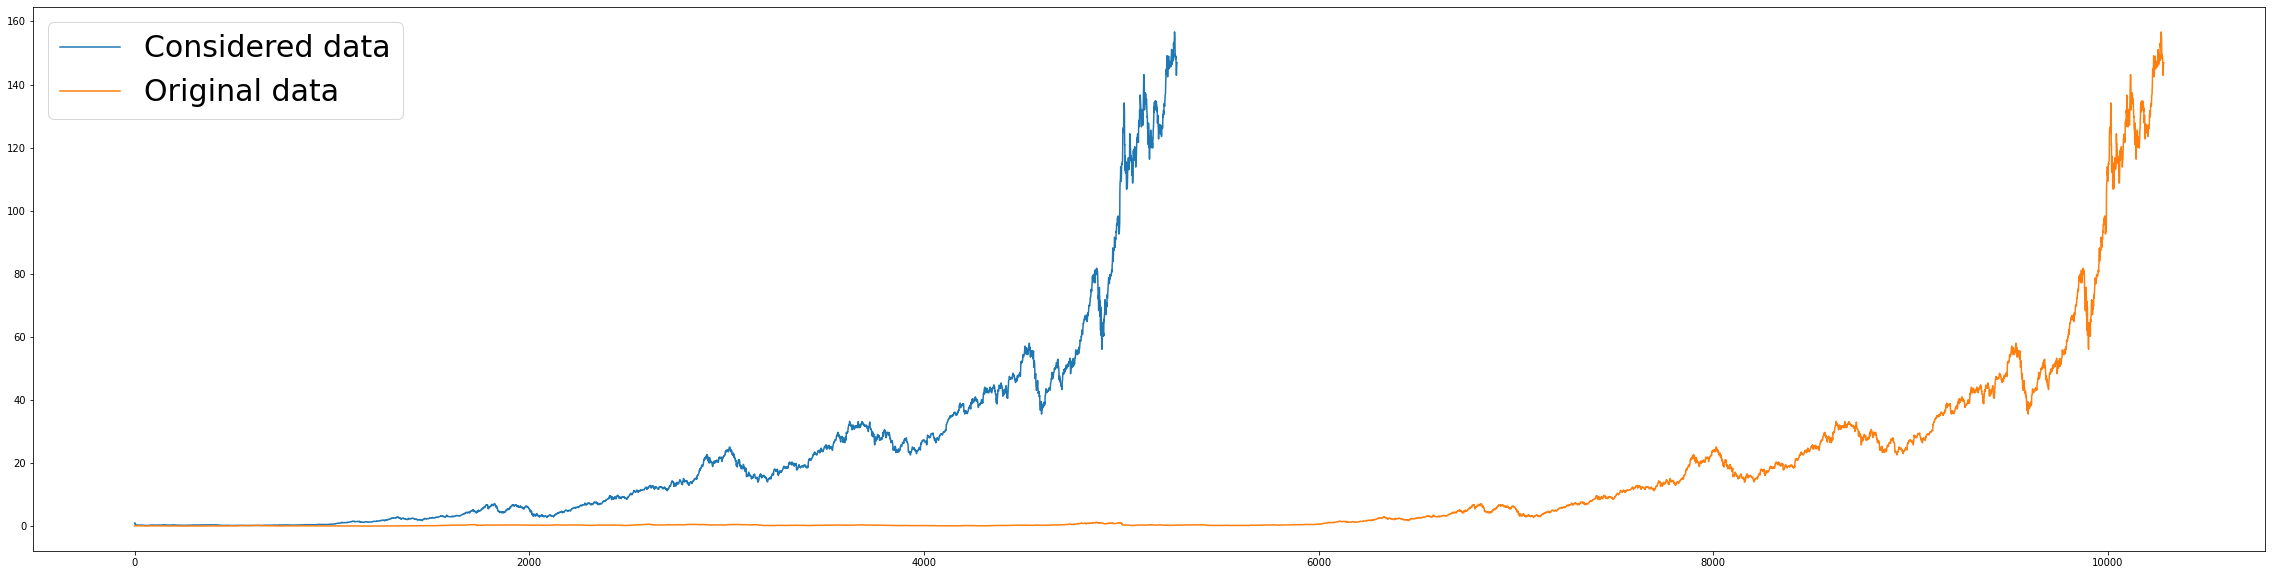

In [2]:
aapl = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv')
#apple = aapl.iloc[:, 4:5].values
apple = aapl.iloc[5000:, 4:5].values
plt.figure(figsize=(40,10))
plt.plot(aapl.iloc[5000:, 4:5].values, label="Considered data")
plt.plot(aapl.iloc[:, 4:5].values, label="Original data")
plt.legend(loc="best", prop={'size': 30})
plt.show()

# 2. Exploring the data

In [3]:
# Converting the data we are working with back to a pandas dataframe so we can use the provided pandas functions
dfc = pd.DataFrame(aapl) 
print("Amount of NA-values: ", dfc.isna().sum())
dfc.head()

Amount of NA-values:  Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600


In [4]:
# Returns summary statistics for the data set
dfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,1.028400e+04
mean,12.166066,12.294925,12.034579,12.169342,11.579424,3.350974e+08
std,25.525863,25.802606,25.240687,25.532322,25.234020,3.403352e+08
min,0.049665,0.049665,0.049107,0.049107,0.038490,0.000000e+00
25%,0.276919,0.284765,0.270508,0.277338,0.232861,1.270752e+08
50%,0.457589,0.464286,0.448661,0.457589,0.379018,2.231704e+08
75%,12.836071,12.866964,12.689197,12.792679,10.984002,4.171944e+08
max,156.979996,157.259995,154.389999,156.690002,156.690002,7.421641e+09


# 3. Commons
Methodology: make it as adaptable as possible.   
Therefore all steps are split up into functions that are delimited in nature.   


### 3.1 Scaling the data
Scaling the data into a range of (0,1).  
This is done for two reasons:  
    - We do not necessarily want to give higher value ranges higher weights       
    - Calculations tend to be less computationally expensive with smaller values     

In [5]:
def scaleData(series):
    """
    scaleData scales input data into a specified range using minmax-scaling

    :param series: a series of numerical values to be scaled
    :return: returns the scaled series
    """ 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    print("Data was successfully scaled.")
    return scaled

### 3.2 Splitting the data 
After the data is scaled, we can split it into our training and test data.   
We train on the train data and train on the test data.
We will do a validation split automatically, later in the project.

In [6]:
def splitData(series, splitPercent=0.8, vsplitPercent=0.2):
    """
    splitData splits time series data into three partition dataset

    :param series: a series of numerical values to be split
    :param splitPercent: optional, the size of the test data compared to the total data in length, is 0.8 by default
                         the size of the test dataset is floored through integer casting
    :param vsplitPercent: the percent of the already splitted testdata that is validation data
    :return: returns the train, validation and test datasets
    """ 
    rowCount = len(series)
    print(rowCount)
    trainAndValSize = int(rowCount * splitPercent) # The trainsize is the floored length(data) * the split% # AssertEquals(4491)
    trainSize = int(trainAndValSize * (1-vsplitPercent)) # AssertEquals(3592)
    testSize = (rowCount-trainAndValSize) # AssertEquals(793)
    valSize = trainAndValSize-trainSize # AssertEquals(899)
    
    train = series[:trainSize] # The training dataset is all data until the trainSize
    val = series[trainSize:trainAndValSize]
    test = series[-testSize:] # The test dataset is all data from the trainSize
    print("Data was successfully split from " + str(rowCount) + " into ", end='')
    print("Train: " + str(len(train)), end=' ')
    print("Test: " + str(len(test)), end=' ')
    print("Validation: " + str(len(val)))
    return train, test, val

### 3.3 Preparing the data
After the data is split, it can needs to be prepared.  
This includes framing the problem.
We want to be able to predict the closing price at x<sub>t+1</sub> using the values (x<sub>t-n</sub>, x<sub>t</sub>), where n is the size of the sliding prediction window.          
In this formulation the values (x<sub>t-n</sub>, x<sub>t</sub>) are the feature, while x<sub>t+1</sub> is the label.     
This transformation is carried out using the prepareData mapping.

In [7]:
def prepareData(series, windowSize):
    """
    prepareData frames the time series into a machine learning problem
            features: (x_t-n, x_t) (for all t in [windowSize, length(series)])
            labels: x_t (for all t in data)

    :param series: a split and scaled series of data to be framed
    :param windowSize: the number of time steps (discrete days?) we look into the past to predict the future value
    :return: returns the features and the labels for the series that can be used for training
    """
    features = []
    labels = []
    for index in range(windowSize, len(series)): # (for all t in [windowSize, length(series)])
        features.append(series[index-windowSize:index, 0]) # (x_t-n, x_t)
        labels.append(series[index, 0]) # x_t
    features, labels = np.array(features), np.array(labels)
    return features, labels

### 3.4 Training the model
After the data has been scaled, split and prepared it is ready to be used for training.  
The model uses the features to make predictions which are then numerically compared to the labels using an cost function.   
We will use a Sequential model for analyzing the time series. We will add LSTM layers to the model that feature dropout layers to combat overfitting. The final layer will be a dense layer with just one unit, to retrieve a single output.
The model is trained with a parameterized number of epochs and batch size.

In [8]:
def lstmModel(tFeatures, tLabels, epochs, batchCount, valX, valY):
    """
    lstmModel creates and trains the model for a specified number of epochs and batch size.
    
    :param tFeatures: the scaled training features of the form (x_t-n, x_t)
    :param tLabels: the label data x_t
    :param epochs: the number of epochs
    :param tLabels: the batch size
    :return: returns model and its history based on a automatic validation split
    """ 
    model = Sequential() # Initiliazing the sequential model
    
    print(valX.shape)
    print(valY.shape)
    
    # Adding LSTM layers to the network, we will use a deep architecture will multiple layers,
    # since that has been shown to increase model performance due to the further level of abstraction
    # deep layers add
    model.add(LSTM(units = 65, return_sequences = True, input_shape=(tFeatures.shape[1], 1)))
    model.add(Dropout(0.15)) # Combatting overfitting
    
    model.add(LSTM(units = 65, return_sequences = True))
    model.add(Dropout(0.15)) # Combatting overfitting
    
    model.add(LSTM(units = 65, return_sequences = True))
    model.add(Dropout(0.15)) # Combatting overfitting
    
    model.add(LSTM(units = 65, return_sequences = False))
    model.add(Dropout(0.15)) # Combatting overfitting
    
    model.add(Dense(units = 25))
    
    model.add(Dense(units = 25))
    
    model.add(Dense(units = 1)) # Final dense/output layer for single output
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
    history = model.fit(tFeatures, tLabels, epochs = epochs, batch_size = batchCount, validation_data=(valX, valY), shuffle=False)
    return model, history

### 3.5 Inverting the scale of predictions
Since the model has learned based on scaled data, are the predictions on new data going to be on the scaled scale as well.
Therefore, the predictions can be inverted to the original scale.

In [9]:
def invertScale(forecasts, series):
    """
    invertScale is the inverse to splitData and reversing the scaling applied to a time series.
    
    :param forecasts: a series of scaled numerical prediction values to be reversed to original scale
    :param series: the actual series before it has been scaled
    :return: returns the inversely scaled series
    """ 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scale = scaler.fit(series) # Fitting the scaler to the original data, to retrieve the original scale
    forecasts_scaled = scale.inverse_transform(forecasts) # Inversing the scaling
    return forecasts_scaled

### 3.6 Visualizing predictions for whole test set
After inverting the prediction we can visualize the predictions for single day prediction over the whole test dataset.

In [10]:
def visualizePredictions(testLength, predictions, windowSize):
    """
    visualizePredictions is a function for visualizing predictions against the real data during that time frame
    
    :param testLength: the length of the test dataset
    :param predictions: the inverted predictions
    :param windowSize: the size of the sliding feature window denoted with n (as before)
    """ 
    # Loding the original data
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-testLength:, 4:5].values
    plt.figure(figsize=(20,10))
    plt.plot(trueData, color='green', label='AAPL') # plotting the actual test data
    predictionX = list(range(windowSize, len(trueData))) # to account for last values not being considered due to out of bounds in preparedata
    plt.plot(predictionX, predictions, color='red', label='Predicted AAPL') # plotting the predictions
    # Misc
    plt.title('LSTM AAPL Single Day Prediction')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend(prop={'size': 15})
    plt.show()

# 4. Recursive multi step prediction
In the following we are attempting to predict multiple time steps into the future.  
Let <i>f</i> denote the forecasting range, <i>t</i> the current time point, and <i>w</i> the window size.   
    For <i>i</i> in [0,<i>f</i>]:        
        1. Extract the last <i>t-w</i> values from the initial data and store it in <i>arr</i>   
        2. Pass <i>arr</i> to the model to predict the value at time <i>x<sub>t+1</sub></i>           
        3. Add this value to <i>arr</i>, and remove the value at <i>arr[0]</i>                        

### 4.1 Making multi step predictions for a single starting time point

In [11]:
# Single Week prediction using recursive strategy/Recursive Multi-step Forecast
# https://machinelearningmastery.com/multi-step-time-series-forecasting/

def makeMultiStepPrediction(lBatch, forecastLength):
    """
    makeMultiStepPrediction makes a multi step forecast with a specified forecast length
    
    :param lBatch: the featurebatch that is used to predict x_t+1
    :param forecastLength: the number of recursive forecasts to be made
    :return: returns an array of forecastLength predictions about (x_t+1,...,x_t+forecastLength)
    """    
    # dynamic numpy array that stores the current feature window in the lstm expected input formatting of 
    # 1,windowSize,1
    lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))
    
    print(lBatchReshaped.shape)
    
    # the prediction at the time x_t+1
    lPrediction = model.predict(lBatchReshaped)
    
    inverteddd = invertScale(lPrediction, apple)
    print(lPrediction, "\n")

    # a dynamic array that stores the current feature window. Represents the dynamically features at the first
    # index of last input batch
    windowX = list(lBatchReshaped[0])
    
    # storing the results retrieved from recursive forecasting
    results = list() 

    for index in range(0, forecastLength):
        windowX.pop(0) # Drop the first observation of the sliding window
        windowX.append(lPrediction[0]) # Append the current prediction
    
        lBatchReshaped[0] = windowX # update the feature window of the feature batch
    
        fPrediction = model.predict(lBatchReshaped) # make the current prediction
    
        fPredictionScaled = invertScale(fPrediction, apple) # invert the prediction
        
        lPrediction[0] = fPrediction # for updating the windowX in the next iteration
        
        results.append(fPredictionScaled) # storing the result
    

    # flattening the result array
    flattenedResults = list()
    for val in results:
        flattenedResults.append(val[0])
        
    return flattenedResults

### 4.2 Making (multiple) multi step predictions at multiple starting points

In [12]:
# timePoints: An array of timepoints that marks the last day of a windowsize-day batch that should be used for
# forecasting
def makeMultiMultiStepPrediction(timePoints, forecastLength):
    """
    makeMultiMultiStepPrediction makes multiple multi step forecasts with a uniform, specified forecast length
    
    :param timePoints: array of time points that feature the index x_t
    :param forecastLength: the number of recursive forecasts to be made
    :return: returns an array of multiple multi step predictions (tensor)
    """ 
    
    # A tensor/3d-numpy-array that stores the results of each multistep prediction at each time step
    # TDLR: A numpy-array that stores for each given time point:
    #           - the predictions (y-coordinates)
    #           - the time frame  (x-coordinates)
    #       each having a length of forecastLength.
    # axis 0: the number of entries in the 3d array, i.e. the number of multi step predictions we are carrying out
    # axis 1: constant 2, since at each 2d-index, the x and y results are stored
    # axis 2: the length of the predictions at each of the multi-step predictions at each index of axis 0
    returnArr = np.zeros((len(timePoints), 2, forecastLength))
    
    # run variable for axis 0 of the tensor
    tmp = 0

    # 0. make a multi step prediction at each time point
    # 1. check if the array of timepoints given is valid with respect to the current windowSize
    # 2. determine the upper and lower bounds of the timeframe, and notably, the value given each index
    #    is the point x_t for the current prediction window
    # 3. pass the current batch to the multistep-function (see above) and store the predictions
    # 4. create the array of x-coordinate values for the new predictions and store in a numpy-array
    # 5. Include 4. (x-coordinates) at index 0 of axis1 and the 3. (y-coordinates) at index 1 of axis1
    # 6. Repeat for all given time points
    for val in timePoints:
        if val < len(test) and val > windowSize:
            upper = -((len(test))-val) # the upper bound of the current time period
            lower = -((len(test))-val)-windowSize # the lower bound of the current time period
            cBatch = np.array(data[lower:upper]) # storing the current batch
            multiStepResults = makeMultiStepPrediction(cBatch, forecastLength) # performing multi step on this batch
            multiStepX = np.arange(val, val+forecastLength) # creating the x-coordinates
            
            returnArr[tmp, 0, :] = multiStepX # x-coordinates
            returnArr[tmp, 1, :] = multiStepResults # y-coordinates
            
            tmp = tmp+1 
        else:
            # We just print out and dont throw an error, since only the first timepoint, and not the following
            # given time points might be valid
            print("Timepoint %d is invalid" % (val)) 
        
    return returnArr

In [13]:
def visualizeMultiMultiStepPrediction(results):
    """
    visualizeMultiMultiStepPrediction is a function for visualizing multiple predictions against the
    whole time frame
    
    :param results: the results of the multi multi step prediction, which contain the inversed x and y coordinates
    """ 
    plt.figure(figsize=(30,15))
    for index in range(0, results.shape[0]):
        lower = results[index, 0, 0]
        upper = results[index, 0, results.shape[2]-1]
        label_ = ("Prediction period: %d - %d" % (lower, upper))
        #plt.plot(results[index, 0, :], results[index, 1, :], label = label_)
        plt.plot(results[index, 0, :], results[index, 1, :], label = label_, color = "red")
        plt.legend(loc="best", prop={'size': 20})
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-len(test):, 4:5].values
    plt.plot(trueData, color="green")
    plt.legend(loc="best", prop={'size': 20})
    plt.show()

# 5. Determining the window size
For determining the optimal window size the acf can be examined. The autocorrelation function should give us an idea to which level the time series is correlated with itself at different lags. The correlation tells us the linear relationship with another time series (in this case our own time series).      
<b>Interpretation:</b>    
    - Positive correlation: If the one time series in/de/creases, so does the other and vice versa.   
    - Negative correlation: If the one time series increases, the other decreases and vice versa.    
    - Zero correlation: There is no clear pattern whatsoever.     

Now its only up to us, to determine a significance level between -1 and 1 (acf is just the acvf "normalized into -1,1") in which negative/positive correlations are significant.   
Looking at the plot, we will choose a significance level of roughly 0.7 (see light blue confidence interval). Judging by the plot, this is the case at rougly 130 lags.


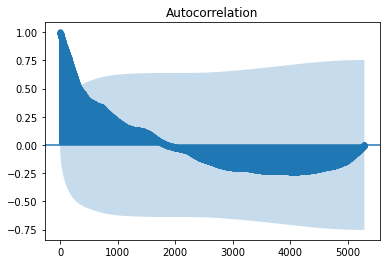

In [14]:
acf_full = tsaplots.plot_acf(apple, lags=len(apple)-1)

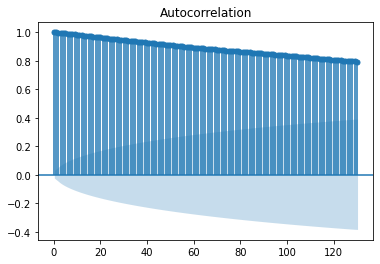

In [15]:
acf_sig_plot = tsaplots.plot_acf(apple, lags=130)

# 6. Visualizing performance indicators

In [16]:
def visualizePerformance(history):
    """
    visualizePerformance presents the performance of the model based on the history retrieved during training
    
    :param history: the history of the model retrieved during training
    """
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

# 7. Forecasting

### 7.1 Preparation

In [17]:
# 7.1.1 scaling the data
data = scaleData(apple)

# 7.1.2 splitting the data
splitPercentage = .85
train, test, val = splitData(data, splitPercentage)

# 7.1.3 Setting the window Size
windowSize = 130

Data was successfully scaled.
5284
Data was successfully split from 5284 into Train: 3592 Test: 793 Validation: 899


### 7.2 Single day prediction

(3462, 130, 1)
(769, 130, 1)
(769,)
Epoch 1/70
28/28 [==============================] - 16s 406ms/step - loss: 5.8281e-04 - mean_squared_error: 5.8281e-04 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 2/70
28/28 [==============================] - 11s 377ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/70
28/28 [==============================] - 10s 369ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 4/70
28/28 [==============================] - 10s 371ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 5/70
28/28 [==============================] - 10s 371ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 6/70
28/28 [==============================] - 10s 372ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0085 - val_mean_

28/28 [==============================] - 11s 377ms/step - loss: 5.3245e-05 - mean_squared_error: 5.3245e-05 - val_loss: 1.4298e-04 - val_mean_squared_error: 1.4298e-04
Epoch 48/70
28/28 [==============================] - 11s 391ms/step - loss: 2.1821e-04 - mean_squared_error: 2.1821e-04 - val_loss: 2.2374e-04 - val_mean_squared_error: 2.2374e-04
Epoch 49/70
28/28 [==============================] - 10s 374ms/step - loss: 1.3909e-04 - mean_squared_error: 1.3909e-04 - val_loss: 2.9468e-04 - val_mean_squared_error: 2.9468e-04
Epoch 50/70
28/28 [==============================] - 10s 373ms/step - loss: 1.1819e-04 - mean_squared_error: 1.1819e-04 - val_loss: 1.6343e-04 - val_mean_squared_error: 1.6343e-04
Epoch 51/70
28/28 [==============================] - 10s 372ms/step - loss: 1.8805e-04 - mean_squared_error: 1.8805e-04 - val_loss: 1.6028e-04 - val_mean_squared_error: 1.6028e-04
Epoch 52/70
28/28 [==============================] - 10s 369ms/step - loss: 2.4193e-04 - mean_squared_error: 2.4

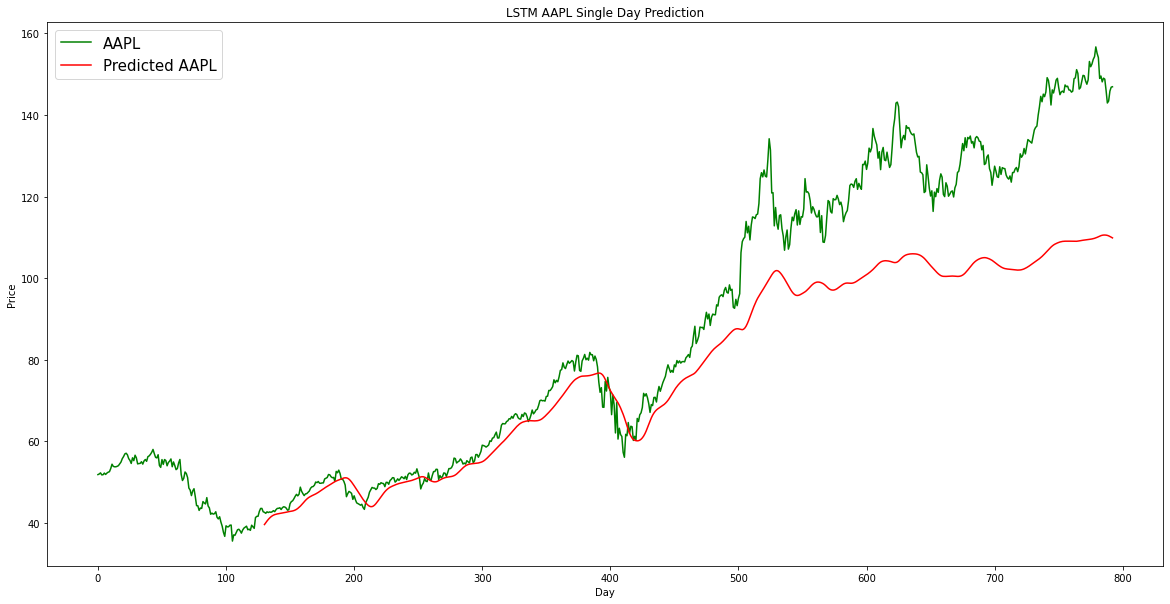

In [18]:
# 7.2.1 formulating the problem and preparing the data (features and labels)
trainFeatures, trainLabels = prepareData(train, windowSize)
testFeatures, testLabels = prepareData(test, windowSize)
valFeatures, valLabels = prepareData(val, windowSize)

# 7.2.2 preparing the features for the lstm model
features = np.reshape(trainFeatures, (trainFeatures.shape[0], trainFeatures.shape[1], 1))

valFeatures = np.reshape(valFeatures, (valFeatures.shape[0], valFeatures.shape[1], 1))
print(features.shape) # (rows, columns, step)

# 7.2.3 training the model
model, history = lstmModel(features, trainLabels, 70, 128, valFeatures, valLabels)

# 7.2.4 testing the single-day prediction on the test set
testFeatures = np.reshape(testFeatures, (testFeatures.shape[0], testFeatures.shape[1], 1))
predictions = model.predict(testFeatures)
predictions = invertScale(predictions, apple)
visualizePredictions(len(test), predictions, windowSize)

### 7.3 Multi-step forecasting

### 7.3.1 20 day and 6 day forecasting into the future

(1, 130, 1)
[[0.6996533]] 

(1, 130, 1)
[[0.6996533]] 



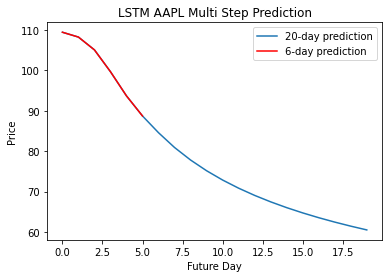

In [19]:
#plt.figure(figsize=(10,8), dpi=300)
# 7.3.1.1 extracting the last batch of data 
lBatch6 = np.array(data[-windowSize:])
lBatch20 = np.array(data[-windowSize:])

# 7.3.1.2 retrieving the results for 20 and for 6 days based on the last data batch
multiStepResults6 = makeMultiStepPrediction(lBatch6, 6)
multiStepResults20 = makeMultiStepPrediction(lBatch20, 20)

# 7.3.1.3 visualizing the results
plt.plot(multiStepResults20, label = "20-day prediction")
plt.plot(multiStepResults6, label = '6-day prediction', color = "red")
plt.xlabel('Future Day')
plt.ylabel('Price')
plt.title('LSTM AAPL Multi Step Prediction')
plt.legend(loc="best")
plt.show()

### 7.3.2 Multi-step forecasting at history time points to have label data

At the previous step (7.3.1) we were able to successfully predict multiple time steps into future, x<sub>t+h</sub> that is.    
However, we are not able to perform any inference on those results since we do not have labels for future data.  
Therefore, we can shift our subjective "now" (x<sub>t</sub>, information about unknown states of the world) back in time.  
In the following we pretend, that our latest data is the data from [x<sub>t-130-130</sub>, x<sub>t-130</sub>].   
This enables us to compare our multistep prediction of [x<sub>t-130+1</sub>, x<sub>t-130+h</sub>] to the actual data of [x<sub>t-130+1</sub>, x<sub>t-130+h</sub>] (where h < 130, but in this case it is 6).

(1, 130, 1)
[[0.6405405]] 



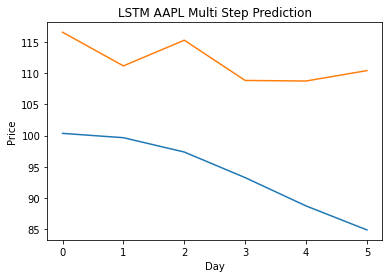

In [20]:
# 7.3.2.1 extract the feature data for [x<sub>t-130-130</sub>, x<sub>t-130</sub>]
lBatch = np.array(data[-windowSize-windowSize:-windowSize])

# 7.3.2.2 perform multi step prediction and retrieve the predictions for the next 6 steps
multiStepResults = makeMultiStepPrediction(lBatch, 6)

# 7.3.2.3 now, we can retrieve the label data for multistep prediction
actualResults = invertScale(np.array(data[-100-windowSize:-100-windowSize+6]), apple)

# 7.3.2.4 visualizing the results by plotting predictions vs. actual data
plt.plot(multiStepResults, label="Predicted values")
plt.plot(actualResults, label="Original data")
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [21]:
lBatch = np.array(data[-windowSize-windowSize:-windowSize])

lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))

print(lBatchReshaped.shape)

predict = model.predict(lBatchReshaped)

predict = invertScale(predict, apple)
print(predict)

(1, 130, 1)
[[100.4505]]


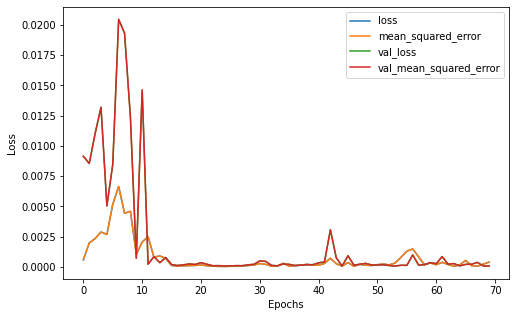

In [22]:
visualizePerformance(history)

### 7.3.3 Making multiple multi step predictions
When employing the methodology from the previous step (7.3.2) we can make multiple multi step forecasts at 
different points in time, in order to visualize how good the model is at performing multi-step predictions.

(1, 130, 1)
[[0.25442573]] 

(1, 130, 1)
[[0.312488]] 

(1, 130, 1)
[[0.35002053]] 

(1, 130, 1)
[[0.46153766]] 

(1, 130, 1)
[[0.46233094]] 

(1, 130, 1)
[[0.6225643]] 

(1, 130, 1)
[[0.6430539]] 

(1, 130, 1)
[[0.66258055]] 

(1, 130, 1)
[[0.69363403]] 



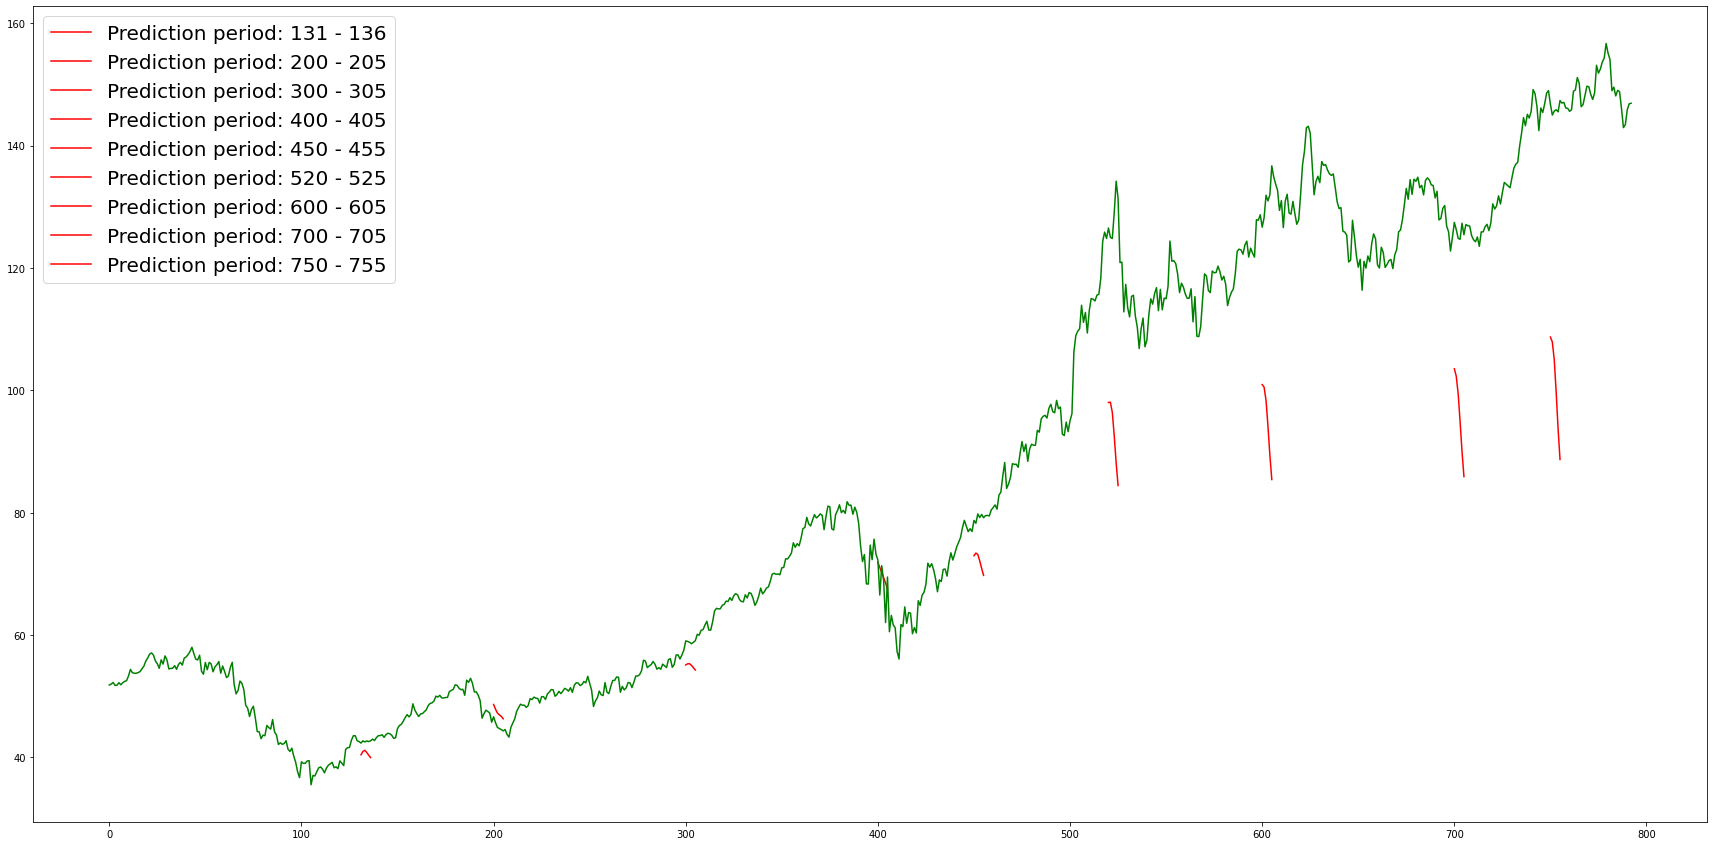

In [23]:
res = makeMultiMultiStepPrediction([131,200, 300, 400, 450, 520, 600, 700, 750],6)
visualizeMultiMultiStepPrediction(res)

In [ ]:
# Saving the final model for future work
#model.save("lstm_aapl_model")